# Классификация в SKTime


## Импорт библиотек

Начнем с импорта нужных библиотек

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [75]:
try:
    import sktime
except:
    !pip install sktime --user
    !pip install tsfresh 
    !pip install numba
    !pip install llvmlite
import sktime

In [76]:
from sktime.transformations.panel.rocket import MiniRocket

In [77]:
from sktime.datasets import load_from_tsfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Импорт данных

Теперь выберем набор данных. Для нашего урока мы воспользуемся уже имеющимся набором данных [открытые данные энергетических систем](https://open-power-system-data.org/). 

In [78]:
url = 'https://data.open-power-system-data.org/time_series/2020-10-06/'
datafile = url + 'time_series_60min_singleindex.csv'
df_all = pd.read_csv(datafile, index_col='utc_timestamp', parse_dates=True, low_memory=False)

Также как и ранее выберем нужную страну, для примеров это была Германия.

In [79]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    """Extract data for a single country"""
    
    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]
    
    # Extract columns and remove country codes from column labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)
    
    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]
        
    return df_out

def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    df = df / 1000
#     df = df.groupby(df.index.hour).mean()
    df = df.rename_axis('Date')
#     df.index = df.index.strftime('%Y-%m-%d-%h')
    return df

In [80]:
df_hrly = extract_country(df_all, country_code='DE', year_min=2015, year_max=2019)
df_hrly.sample(3)

cols_map = {'load_actual_entsoe_transparency' : 'Consumption',
            'wind_generation_actual' : 'Wind',
            'solar_generation_actual' : 'Solar'}
df = transform_dataframe(df_hrly, cols_map).dropna()

# df wind + solar generation
df['Wind+Solar'] = df[['Wind', 'Solar']].sum(axis=1, skipna=False)
df.to_csv('de_clf_data.csv')
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01 07:00:00+00:00,41.133,10.208,0.071,10.279
2015-01-01 08:00:00+00:00,42.963,10.029,0.773,10.802
2015-01-01 09:00:00+00:00,45.088,10.550,2.117,12.667
2015-01-01 10:00:00+00:00,47.013,11.390,3.364,14.754
2015-01-01 11:00:00+00:00,48.159,12.103,4.198,16.301


Однако для текущей цели - изучить классификацию временных рядов давайте сделаем набор данных с классами. Для этого предлагается поставить задачу определение по дневному потреблению сезона (зима, весна, осень, лето):
* Разделить все данные на 4 сезона (зима, весна, осень, лето)
* взять данные с шагом 1 час.
* создать сегменты размером 24 часа (1 день).

Данная задача полностью искусственная, однако в целом соответствует некоторым из задачи стандартных тестов классификации временных рядов, например смотрите [тут](http://www.timeseriesclassification.com/description.php?Dataset=PowerCons). 

Напомним, что для проведения классификации, как правило, данные следует разделять на сегменты.  Как правило, эти сегменты не должны пересекаться. В нашем случае длина сегмента будет 24 точки.

Для цели создания набора данных давайте создадим 2 функции, первая `split_by_month` будет разделять наш набор данных на месяца. Вторая функция `to_segments` будет создавать сегменты по 24 часа в сутках.

In [81]:
def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):
        df_ = df_.append(df.loc[df.index.month == month])
    return df_

def to_segments(df, column, size = 24):  
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

In [82]:
winter = to_segments(split_by_month(df, [1,2, 12]), 'Consumption', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'Consumption', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'Consumption', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'Consumption', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)

(448, 24) (458, 24) (452, 24) (458, 24)


Теперь мы создали 4 класса. Давайте посмотрим как выглядят их примеры.

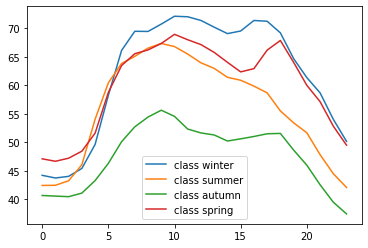

In [83]:
plt.figure()
day = 10
for i,(c,d) in enumerate(zip([winter,summer,autumn,spring],['winter','summer','autumn','spring'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

Хотя примеры показывают  высокую степень сходства мы все же попробуем их классифицировать. Для этого создадим массив тренировочных и тестовых данных.

In [84]:
X = np.concatenate((
                    winter, 
                    summer, 
                    autumn, 
                    spring))
y = np.concatenate((
                    0*np.ones(winter.shape[0]),
                    1*np.ones(summer.shape[0]),
                    2*np.ones(autumn.shape[0]),
                    3*np.ones(spring.shape[0])
                   ))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1271, 24) (1271,) (545, 24) (545,)


Современная версия `SKTime` допускает формат массивов в виде `2d ndarray (numpy)` для однопеременных временных рядов. Для многопеременных временных рядов массив может быть задан в виде `3d ndarray`. В общем случае однопеменный ряд также может быть задан как многопеременный с размерностью массива $\text{samples} \times \text{variable} \times \text{segment}$ Также в пакете `SKTime` предусмотрены и другие форматы. В том числе специализированные. Для преобразования между форматами используются `convert` и `convert_to` из модуля `sktime.datatypes`. Например, для преобразования двухмерного массива во встроенный однопеременных формат можно воспользоваться следующим скриптом
```python
    df = convert_to(np.atleast_3d(X).transpose(0,2,1), to_type="nested_univ") 
```
Однако  не все функции `SKTime` поддерживают `2d ndarray` поэтому давайте создадим `nested_univ` копии данных.

In [85]:
from sktime.datatypes import convert_to
df_train = convert_to(np.atleast_3d(X_train).transpose(0,2,1), to_type="nested_univ") 
df_test  = convert_to(np.atleast_3d(X_test ).transpose(0,2,1), to_type="nested_univ") 

## Классификация sklearn

Перед тестированием специализированных методов из пакета `SKTime` давайте посмотрим на результаты стандартных подходов из `sklearn`. В анализе временных рядов среди таких стандартных подходов наиболее распространен `случайный лес`. Также давайте попробуем алгоритм `k-соседей` с евклидовым расстоянием как некоторую предварительную базовую оценку.

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')


 test score 0.881


In [87]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}') 

 test score 0.879


## Классификаторы на основе данных

В теоретической части мы уже обсуждали типы алгоритмов классификации временных рядов. Теперь давайте попробуем их на практике. Ранее мы обсуждали что в качестве некоторой базовой оценки можно использовать `1-NN DTW` классификатор. Напомним, что этот подход сравнивает временные ряды "в целом". Расстояние `DTW` относится к эластичным мерам, стабильным к искажениям различных сегментов ряда.

В пакете `SKTime` данный тип алгоритмов находится в модуле `distance_based`.

In [88]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.839


Полученный результат не превзошёл результат с евклидовым расстоянием. Вероятно, это связано с близостью форм сегментов. Однако `1-NN DTW` может быть реализован и в более продвинутых формах. Одной из таких форм является расстояние разностей `ddtw`. 

In [89]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.917


Другим вариантом классификатора на основе данных являются шейплет классификатора. Напомним, что шейплет представляет собой участок временного ряда, обладающий наибольшей дискриминационной способностью для задачи. Другими словами, для участков шейплетов различия между классами наиболее существенны.

В ракете `SKTime` шейплеты могут быть найдены в модуле `sktime.classification.shapelet_based`.

In [90]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier

clf = ShapeletTransformClassifier(estimator=RandomForestClassifier(n_estimators=100),
                                  n_shapelet_samples=100,
                                  max_shapelets=100,
                                  batch_size=20)

clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.916


Классификаторы на основе шейплетов позволяют найти наиболее различающиеся паттерны в данных. Как обсуждалось в теоретической части в ряде случаев более полезным оказываться повторяемость такие паттернов.  В таких и подобных задачах для описания временных рядов (для их представления) могут быть использованы подходы на основе т.н. словаря (Dictionary-based). 

В пакете `SKTime` для работы со словарями используется модуль `sktime.classification.dictionary_based`. 

In [91]:
from sktime.classification.dictionary_based import (ContractableBOSS, 
                                                    IndividualBOSS, 
                                                    IndividualTDE, 
                                                    MUSE, WEASEL)

In [92]:
clf = IndividualBOSS(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8110091743119267

In [93]:
clf = IndividualTDE(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8403669724770643

In [94]:
clf = MUSE(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9504587155963303

## Классификаторы на основе признаков

Классификаторы, рассмотрены выше можно было отнести к т.н. классификаторам на основе данных. Однако как уже обсуждалось в теоретической части, часто следует отдавать предпочтения классификаторам на основе признаков. Одними из наиболее популярных подходов среди таких классификаторов являются интервальные подходы. Суть таких подходов сводится к
* поиску или случайному выбору интервалов внутри временных рядов;
* извлечению некоторого набора признаков для такого интервала;
* построению некоторого классификатора, например, дерева для каждого интервала;
* объединение результатов для всех интервалов, например, при помощи леса деревьев.

В пакете `SKTime` такие методы могут быть найдены в модуле `sktime.classification.interval_based`.

In [95]:
from sktime.classification.interval_based import (TimeSeriesForestClassifier, 
                                                  RandomIntervalSpectralEnsemble, 
                                                  SupervisedTimeSeriesForest)

In [96]:
clf = TimeSeriesForestClassifier(n_estimators=100,random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.947


In [97]:
clf = RandomIntervalSpectralEnsemble(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.934


In [98]:
clf = SupervisedTimeSeriesForest(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.947


Помимо алгоритмов на основе деревьев, популярным на сегодня является методы на основе ядерных преобразований. Одним из наиболее успешных алгоритмов в этом направлении является алгоритм `Rocket`. Суть данного алгоритма сводится к трансформации данных при помощи набора сверточных ядре со случайно выбранными параметрами. Затем авторы рекомендуются использовать  `RidgeClassifierCV`, который предоставляет собой Логистическую регрессию с `L2` регуляризацией, параметр регуляризации выбирается при помощи кросс-валидации. 

Мы рассмотрим ускоренную версию преобразования `MiniRocket`. 

In [99]:
from sklearn.linear_model import RidgeClassifierCV

transform = MiniRocket(num_kernels=10000, n_jobs = -1)
Xt_train = transform.fit_transform(X_train)
Xt_test  = transform.transform(X_test)

clf = RidgeClassifierCV()
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.912


Другим важным подходом на основе признаков является подход выбора признакового пространства. Таким пространством может быть лишь использование небольшого числа суммарных статистик (среднее, медиана, дисперсия и т.д.), которые должны как-то описать временной ряд. 

В некоторых случаях суммарных статистик может быть недостаточно. В общем случае помимо суммарных статистик могут быть и 
Временные или частотные (псевдочастотные) признаки. Давайте перечислим примеры таких признаков в виде списка:
* суммарные статистики: среднее, медиана, дисперсия, энтропия и т.д.;
* временные признаки: наклон, характер тренда, точки пересечения некоторых пороговых значений, значения пиков и их позиции, автокорреляционные коэффициенты и т.д. 
* частотные признаки: значения пиков спектра, коэффициенты авторегрессии, коэффициенты, например, вейвлет разложений и т.д.
* другие признаки.
В общем случае признаковые пространства могут быть достаточно объемными. Однако, как правило, не все признаки важны, поэтому для таких пространств следует проводить отбор признаков. Существуют и готовые решения, где из объемных пространств уже выделены некоторые наиболее значимые подпространства. Среди таких подходов популярным является `Catch22`. В данном подходе среди порядка `4500` признаков выделено `22`, имеющих большую значимость для стандартных тестов. 

В пакете `SKTime` описанные подходы можно найти в модуле `sktime.classification.feature_based`. Давайте протестируем 2 классификатора из этого пакета `SummaryClassifier`, представляющий описание временных рядов суммарными статистиками и `Catch22Classifier`, представляющий описание временного ряда указанным выше признаковым пространством. 

In [100]:
from sktime.classification.feature_based import SummaryClassifier, Catch22Classifier
from sklearn.ensemble import RandomForestClassifier

In [101]:
clf = SummaryClassifier(estimator=RandomForestClassifier(n_estimators=100))
clf.fit(X_train, y_train)
print(f' test score {clf.score(df_test, y_test):.3f}')

 test score 0.631


In [102]:
clf = Catch22Classifier(estimator=RandomForestClassifier(n_estimators=100))
clf.fit(X_train, y_train)
print(f' test score {clf.score(df_test, y_test):.3f}')

 test score 0.839


Дополнительно отметим, что пакет `SKTime` также позволяет создавать пайплайны выделения признаков и классификации в ручном режиме. Например, так, как это показано ниже. Показанный пример повторяет алгоритм `TimeSeriesForestClassifier`, однако, не полностью.

In [103]:
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sktime.utils.slope_and_trend import _slope
from sklearn.pipeline import Pipeline

steps = [(
        "extract",  RandomIntervalFeatureExtractor(
            n_intervals="sqrt", features=[np.mean, np.std, _slope]
        )),
    ("clf", RandomForestClassifier()),]

clf = Pipeline(steps)
clf.fit(df_train, y_train)
print(f' test score {clf.score(df_test, y_test):.3f}')

 test score 0.910


Также важно отметить возможность работы с некоторыми другими библиотеками работы с признаками. Так, одной из наиболее популярных библиотек является [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/introduction.html). Данная библиотека является достаточно популярной, хотя и не самой современной. На данный момент ведется интеграция функционала `tsfresh` в `SKTime`. По этому мы покажем возможность работы с `tsfresh` как с отдельным инструментом. 

В самом простом случае `tsfresh` требует формат данных в виде DataFrame, в котором все сегменты данных были бы представлены в одной колонке (для однопеременных данных). Для преобразования форматов воспользуемся встроенной функцией `sktime` `from_nested_to_long`.

Для выделения признаков `tsfresh` используется метод `extract_features`. 

In [104]:
from tsfresh import extract_features
from sklearn.preprocessing import MinMaxScaler
from sktime.datatypes._panel._convert import from_nested_to_long

In [111]:
Xt_train = extract_features(
            from_nested_to_long(df_train),
            column_id="index",
            column_value="value",
            column_kind="column",
            column_sort="time_index", )
Xt_train.head(2)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.24s/it]


,var_0__variance_larger_than_standard_deviation,var_0__has_duplicate_max,var_0__has_duplicate_min,var_0__has_duplicate,var_0__sum_values,var_0__abs_energy,var_0__mean_abs_change,var_0__mean_change,var_0__mean_second_derivative_central,var_0__median,...,var_0__permutation_entropy__dimension_6__tau_1,var_0__permutation_entropy__dimension_7__tau_1,var_0__query_similarity_count__query_None__threshold_0.0,"var_0__matrix_profile__feature_""min""__threshold_0.98","var_0__matrix_profile__feature_""max""__threshold_0.98","var_0__matrix_profile__feature_""mean""__threshold_0.98","var_0__matrix_profile__feature_""median""__threshold_0.98","var_0__matrix_profile__feature_""25""__threshold_0.98","var_0__matrix_profile__feature_""75""__threshold_0.98",var_0__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,1147.970,55546.291492,1.706478,0.143348,-0.034932,49.0810,...,2.798513,2.890372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.385857
1,1.0,0.0,0.0,0.0,1196.845,60363.754601,1.768826,-0.150478,-0.048023,51.6575,...,2.360736,2.630253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.839714


In [112]:
Xt_test = extract_features(
            from_nested_to_long(df_test),
            column_id="index",
            column_value="value",
            column_kind="column",
            column_sort="time_index", )
Xt_test.head(2)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.38s/it]


,var_0__variance_larger_than_standard_deviation,var_0__has_duplicate_max,var_0__has_duplicate_min,var_0__has_duplicate,var_0__sum_values,var_0__abs_energy,var_0__mean_abs_change,var_0__mean_change,var_0__mean_second_derivative_central,var_0__median,...,var_0__permutation_entropy__dimension_6__tau_1,var_0__permutation_entropy__dimension_7__tau_1,var_0__query_similarity_count__query_None__threshold_0.0,"var_0__matrix_profile__feature_""min""__threshold_0.98","var_0__matrix_profile__feature_""max""__threshold_0.98","var_0__matrix_profile__feature_""mean""__threshold_0.98","var_0__matrix_profile__feature_""median""__threshold_0.98","var_0__matrix_profile__feature_""25""__threshold_0.98","var_0__matrix_profile__feature_""75""__threshold_0.98",var_0__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,1477.696,92362.073364,2.077826,0.024783,-0.073591,65.723,...,2.625048,2.813355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.742857
1,1.0,0.0,0.0,1.0,1034.632,45115.251980,1.206522,0.167826,0.053455,45.234,...,2.698011,2.890372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.743143


И так мы выделили 789 признаков. Среди признаков есть значения достаточно разных порядков, а также отсутствующие значения.
Проведем стандартизацию полученных признаков.

In [113]:
Xt_train = (Xt_train - Xt_train.min())/(Xt_train.max() - Xt_train.min()).astype(np.float32)
Xt_test  = (Xt_test  - Xt_train.min())/(Xt_train.max() - Xt_train.min()).astype(np.float32)

In [114]:
Xt_train = Xt_train.dropna(axis=1)
Xt_test  = Xt_test[Xt_train.columns]

In [115]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(Xt_train, y_train)
clf.score(Xt_test, y_test)

0.5798165137614679

Отметим, что при необходимости в пакете `SKTime` можно найти и ряд не рассмотренных тут преобразований, техник выделения признаков и техник классификации временных рядов. 